In [32]:
# https://arxiv.org/pdf/2012.07122

import matplotlib.pyplot as plt 
from PIL import Image

image_path = "carpet/train/good/000.png"

image = Image.open(image_path)
print(image.size)

(1024, 1024)


In [33]:
from torchvision.transforms import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224))
])

image = transform(image)


In [34]:
image.numel() * image.element_size() * 279  // 1024


164052

In [35]:
from torchvision.datasets import ImageFolder

train_image_path = "carpet/train"

good_dataset = ImageFolder(root=train_image_path,transform=transform)

x , y = good_dataset[0]

print(x.shape , y)

torch.Size([3, 224, 224]) 0


In [6]:
import torch
import torch.utils
import torch.utils.data

train_dataset , test_dataset = torch.utils.data.random_split(good_dataset,[0.8,0.2])

print(len(good_dataset) , len(train_dataset) , len(test_dataset))

280 224 56


In [36]:
import torch
from torch.utils.data import DataLoader

BATCH_SIZE = 16 

train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True)

image_batch , label_batch = next(iter(train_loader))

print(image_batch.shape , label_batch.shape)

memory = image_batch.numel() * image_batch.element_size()

print(memory)

torch.Size([16, 3, 224, 224]) torch.Size([16])
9633792


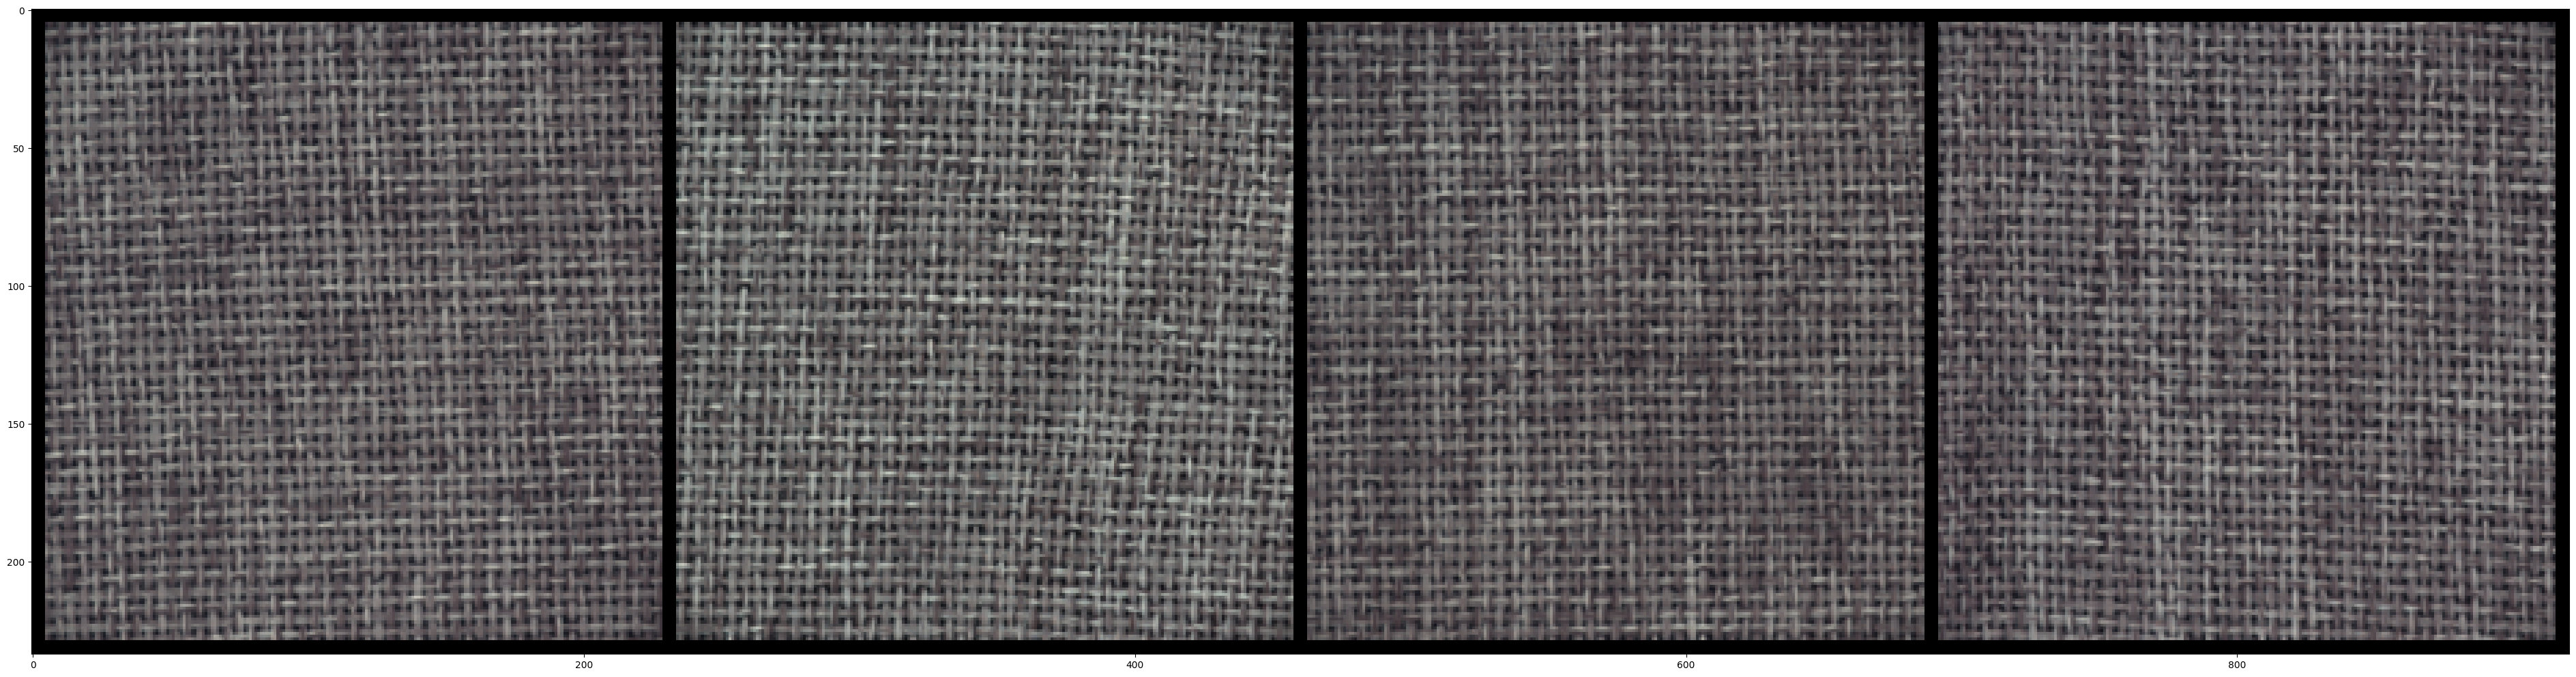

In [37]:
plt.figure(figsize=(12 * 4 , 48 * 4 ))

import torchvision

grid = torchvision.utils.make_grid(image_batch[0:4],padding=5,nrow=4)
plt.imshow(grid.permute(1,2,0))
plt.show()

In [38]:
import torch.nn.functional as F 
from torch import nn

input_image = Image.open("carpet/train/good/000.png")
input_image = transform(input_image)

print(input_image.unsqueeze(0).shape)

c1 = nn.Conv2d(in_channels=3, out_channels=128,kernel_size=4)
x = c1(input_image)
print(x.shape)

avp1 = nn.AvgPool2d(kernel_size=2,stride=2)
x = avp1(x)
print(x.shape)

c2 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=4)
avp2 = nn.AvgPool2d(kernel_size=2,stride=2)
x = avp2(c2(x))
print(x.shape)

c3 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3)
avp3 = nn.AvgPool2d(kernel_size=2,stride=2)
x = avp3(c3(x))
print(x.shape)

c4 = nn.ConvTranspose2d(in_channels=256,out_channels=256,kernel_size=4,stride=2,output_padding=1)
x = c4(x)
print(x.shape)

c5 = nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=5,stride=2,output_padding=1)
x = c5(x)
print(x.shape)

c6 = nn.ConvTranspose2d(in_channels=128,out_channels=3,kernel_size=5,stride=2,output_padding=1)
x = c6(x)
print(x.shape)



torch.Size([1, 3, 224, 224])
torch.Size([128, 221, 221])
torch.Size([128, 110, 110])
torch.Size([256, 53, 53])
torch.Size([256, 25, 25])
torch.Size([256, 53, 53])
torch.Size([128, 110, 110])
torch.Size([3, 224, 224])


In [39]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3,128,kernel_size=4),
            nn.ReLU(),
            
            nn.AvgPool2d(kernel_size=2,stride=2),
            nn.Conv2d(128,256,kernel_size=4),
            nn.ReLU(),
            
            nn.AvgPool2d(kernel_size=2,stride=2),
            nn.Conv2d(256,256,kernel_size=3),
            nn.ReLU(),
            
            nn.AvgPool2d(kernel_size=2,stride=2)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256,256,kernel_size=4,stride=2,output_padding=1),
            nn.ReLU(),
            
            nn.ConvTranspose2d(256,128,kernel_size=5,stride=2,output_padding=1),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128,3,kernel_size=5,stride=2,output_padding=1),
            nn.Sigmoid()
        )
        
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x 
    
    
model = Autoencoder()
output_image = model(input_image)

print(output_image.shape)

torch.Size([3, 224, 224])


In [40]:
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(),lr=0.0001)



In [41]:
from tqdm import tqdm

In [12]:
num_epochs = 100

Loss = []
validation_loss = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    for img , _ in train_loader:
        print(img.shape)
        output = model(img)
        
        loss = criterion(output,img)
        
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    Loss.append(loss.item())
    model.eval()
    
    with torch.no_grad():
        val_loss_sum = 0.0
        num_batches = 0
        
        for img , _ in test_loader:
            output = model(img)
            val_loss = criterion(output,img)
            val_loss_sum += val_loss.item()
            num_batches += 1
        
        val_loss_avg = val_loss_sum / num_batches
        validation_loss.append(val_loss_avg)
    
    if epoch % 5 == 0 : 
        print('Epoch [{}/{}],loss : {:4f},validation_loss : {:4f}'.format(epoch + 1 ,num_epochs,loss.item(), val_loss_avg)) 
        
print('-----')

plt.plot(Loss,label='Training Loss')
plt.plot(validation_loss , label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()

plt.show()


  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([16, 3, 224, 224])


  0%|          | 0/100 [00:11<?, ?it/s]


KeyboardInterrupt: 

In [14]:
torch.save(model.state_dict(),'auto_encoder_l2_loss.pth')
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(128, 3, kernel_size=(5, 5), stride=(2, 2), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [ ]:
https://www.youtube.com/watch?v=pDnwcDxGfTY&list=PLoSULBSCtofdd9Lbp_6uDV0Vqet0afri5&index=5

In [42]:
with torch.no_grad():
    for data , _ in train_loader:
        recon = model(data)
        break
    
recon_error = ((data - recon)**2).mean(axis=1)
print(recon_error.shape)


torch.Size([16, 224, 224])


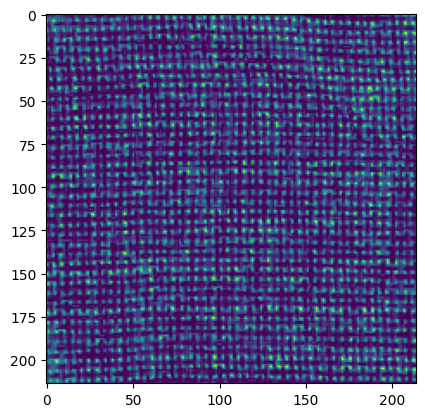

In [43]:
plt.imshow(recon_error[0][0:-10,0:-10].cpu().numpy())

<Figure size 1600x1200 with 0 Axes>

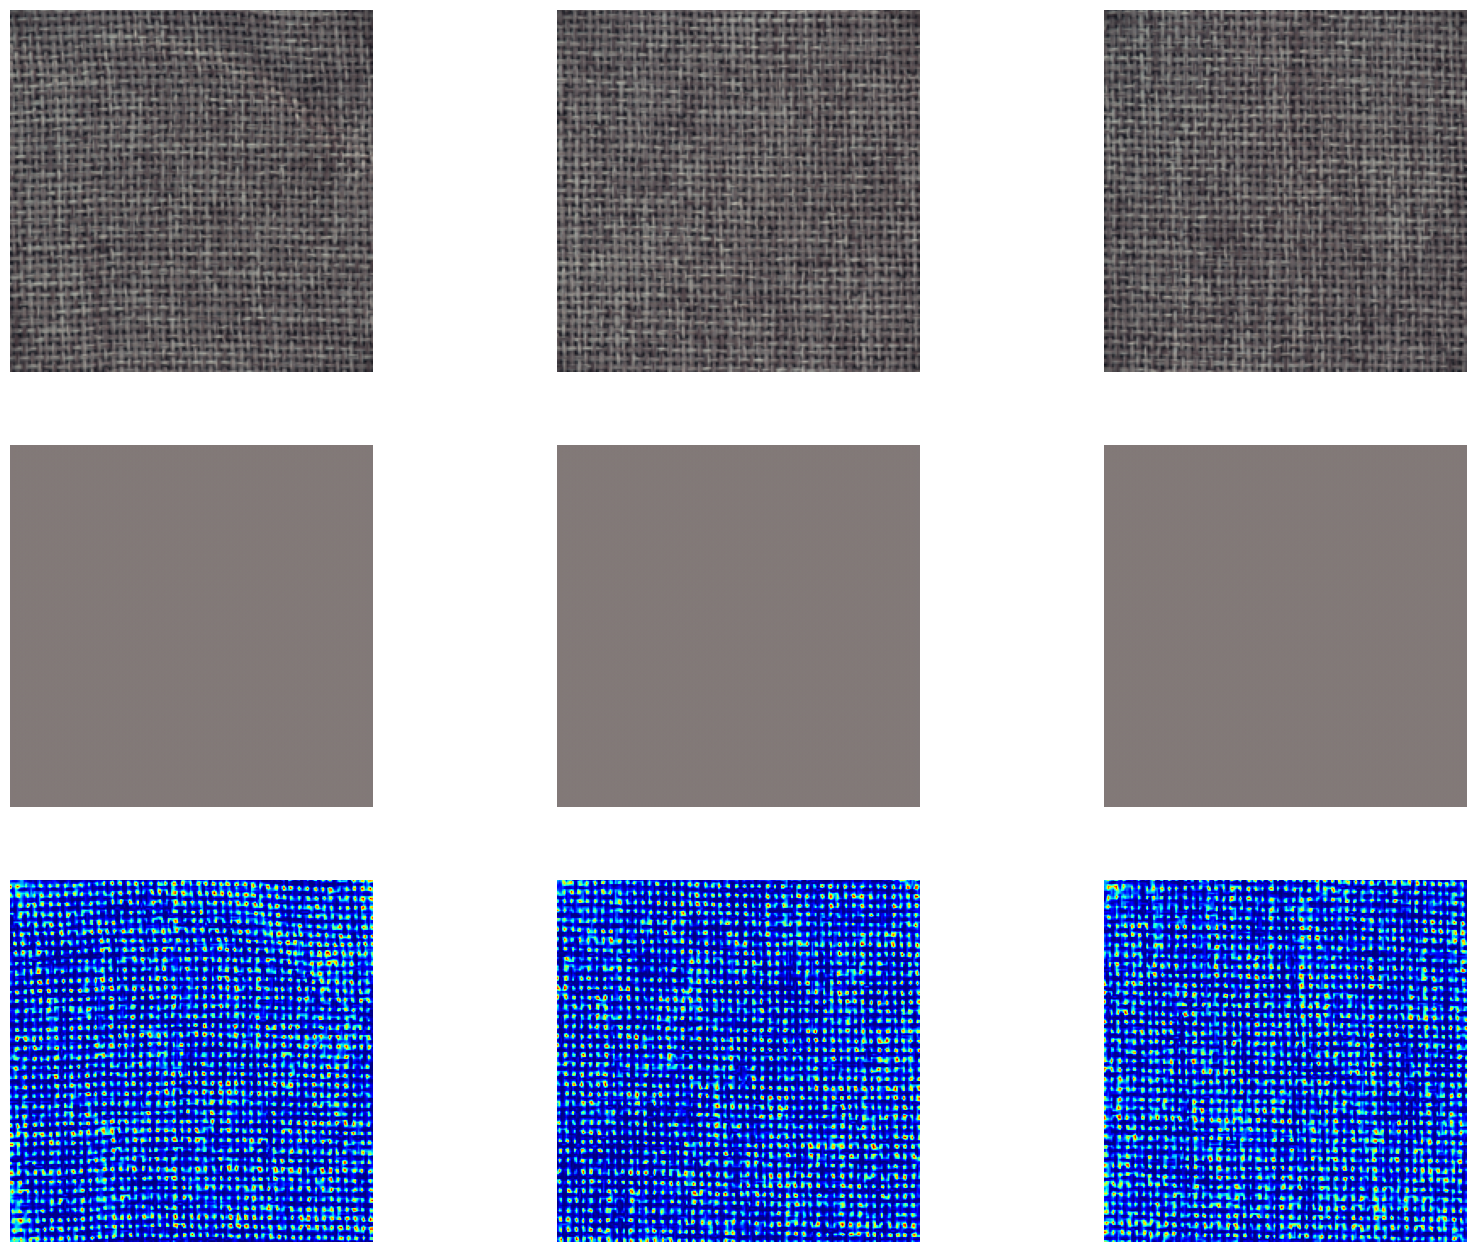

In [44]:
plt.figure(dpi=250)
fig , ax = plt.subplots(3,3,figsize=(5*4  , 4*4))
for i in range(3): 
    ax[0,i].imshow(data[i].cpu().numpy().transpose(1,2,0))
    ax[1,i].imshow(recon[i].cpu().numpy().transpose(1,2,0))
    ax[2,i].imshow(recon_error[i][0:-10,0:-10].cpu().numpy(),cmap='jet',vmax=torch.max(recon_error[i]))
    ax[0,i].axis('OFF')
    ax[1,i].axis('OFF')
    ax[2,i].axis('OFF')

plt.show()


In [45]:
test_image_color = transform(Image.open("carpet/test/color/004.png"))

data = torch.stack([test_image_color])

with torch.no_grad():
    recon = model(data)
    
recon_error = ( ( data - recon) ** 2 ).mean(axis=1)

(-0.5, 213.5, 213.5, -0.5)

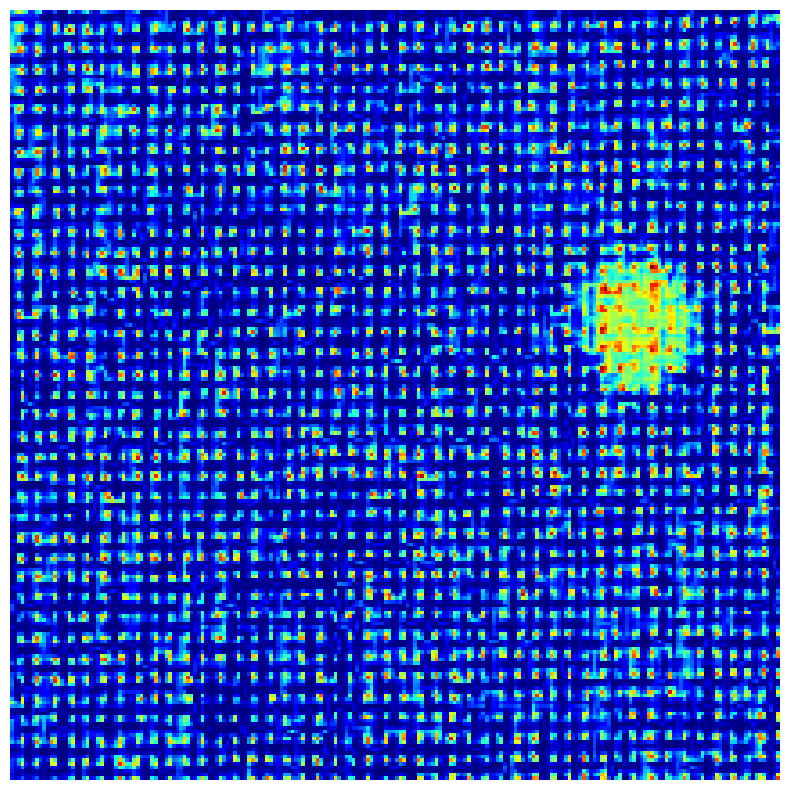

In [46]:
plt.figure(figsize=(10, 10))
plt.imshow(data[0].cpu().numpy().transpose(1,2,0))
plt.imshow(recon[0].cpu().numpy().transpose(1,2,0))
plt.imshow(recon_error[0][0:-10,0:-10].cpu().numpy(),cmap='jet',vmax=torch.max(recon_error[0]))
plt.axis('OFF')
plt.axis('OFF')
plt.axis('OFF')

In [47]:
# fault accuracy 

RECON_ERROR = []

with torch.no_grad():
    for data , _ in train_loader:
        recon = model(data)
        data_recon_squared_mean = ( ( data - recon) ** 2 ).mean(axis=1)[:,0 :-10,0:-10].mean(axis=(1,2))
        
        RECON_ERROR.append(data_recon_squared_mean)
        
RECON_ERROR = torch.cat(RECON_ERROR).cpu().numpy()
        

AttributeError: module 'numpy' has no attribute 'matrix'

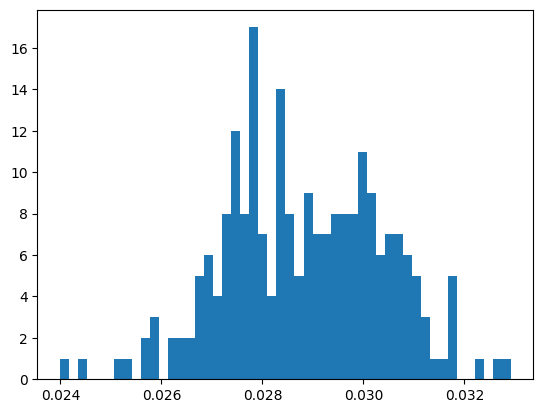

In [49]:
import numpy as np

best_threshold = np.mean(RECON_ERROR) + 3 * np.std(RECON_ERROR)

plt.hist(RECON_ERROR,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=50,colors='r')
plt.show()

In [50]:
from pathlib import Path

y_true = []
y_pred = []
y_score = []

model.eval()

with torch.no_grad():
    test_path = Path("carpet/test")
    
    for path in test_path.glob('*/*.png'):
        fault_type = path.parts[-2]
        
        test_image = transform(Image.open(path)).unsqueeze(0)
        recon_image = model(test_image)
        
        y_score_image = ((test_image - recon_image)**2).mean(axis=1)[:,0:-10,0:-10].mean()
        y_pred_image = 1 * (y_score_image >= best_threshold)
        y_true_image = 0 if fault_type == 'good' else 1
        
        y_true.append(y_true_image)
        y_pred.append(y_pred_image.cpu())
        y_score.append(y_score_image.cpu())
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)
        
        

AttributeError: module 'numpy' has no attribute 'matrix'

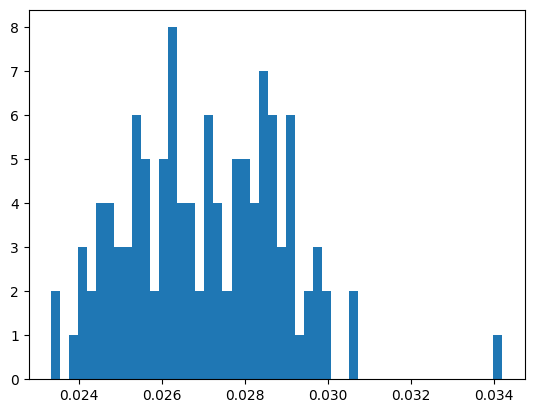

In [52]:
plt.hist(y_score,bins=50)
plt.vlines(x=best_threshold , ymin=0,ymax=30,color='r')
plt.show()

In [53]:
from sklearn.metrics import roc_auc_score , roc_curve , ConfusionMatrixDisplay , f1_score
import seaborn as sns 

auc_roc_score = roc_auc_score(y_true,y_score)
print("auc roc score" , auc_roc_score)

fpr , tpr , threshold = roc_curve(y_true,y_score)

plt.figure()

plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC Curve , area = %0.2f' % auc_roc_score)
plt.plot([0,1],[1,0],color='navy',lw=2,linestyle='--')
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.title("ROC")
plt.legend()
plt.show()

AttributeError: module 'numpy.random' has no attribute 'mtrand'

In [54]:
import torch.optim as optim
from torchvision.models import resnet50 , ResNet50_Weights



In [55]:
import torch.utils
import torch.utils.data


_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

train_image_path = "carpet/train"

good_dataset = ImageFolder(root=train_image_path,transform=_transform)
train_dataset , test_dataset = torch.utils.data.random_split(good_dataset,[0.8,0.2])

BATCH_SIZE = 16 

train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True)



In [56]:
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)


In [57]:
for name in resnet_model.named_parameters():
    print(name[0])

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

In [58]:
feature = []

def hook(model , input , output):
    feature.append(output.detach())
    
resnet_model.layer2[-1].register_forward_hook(hook)
resnet_model.layer3[-1].register_forward_hook(hook)

In [59]:
resnet_model.layer2[-1].register_forward_hook(hook)
resnet_model.layer3[-1].register_forward_hook(hook)

In [60]:
_ = resnet_model(torch.randn(1,3,224,224))

In [61]:
feature[1].shape

torch.Size([1, 1024, 14, 14])

In [62]:
class resnet_feature_extractor(nn.Module):
    def __init__(self):
        super(resnet_feature_extractor,self).__init__()
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)
        
        self.model.eval()
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        def hook(module, input, output):
            self.feature.append(output)
            
        self.model.layer2[-1].register_forward_hook(hook) 
        self.model.layer3[-1].register_forward_hook(hook) 
        
    def forward(self, x):
        self.feature = []
        
        with torch.no_grad():   
            _ = self.model(x)
            
        self.avg_p = torch.nn.AvgPool2d(3,stride=1)
        fmap_size = self.feature[0].shape[-2]
        
        self.resize = torch.nn.AdaptiveAvgPool2d(fmap_size)
        
        resized_maps = [self.resize(self.avg_p(fmap)) for fmap in self.feature]
        patch = torch.cat(resized_maps, dim=1)
        
        return patch

In [63]:
_image = Image.open('carpet/test/color/000.png')
_image = transform(_image).unsqueeze(0)

backbone = resnet_feature_extractor()
features = backbone(_image)

print(features.shape)

print(backbone.feature[0].shape)
print(backbone.feature[1].shape)


torch.Size([1, 1536, 28, 28])
torch.Size([1, 512, 28, 28])
torch.Size([1, 1024, 14, 14])


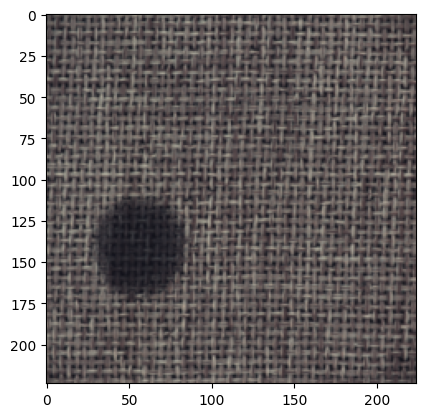

In [64]:
plt.imshow(_image[0].permute(1,2,0))

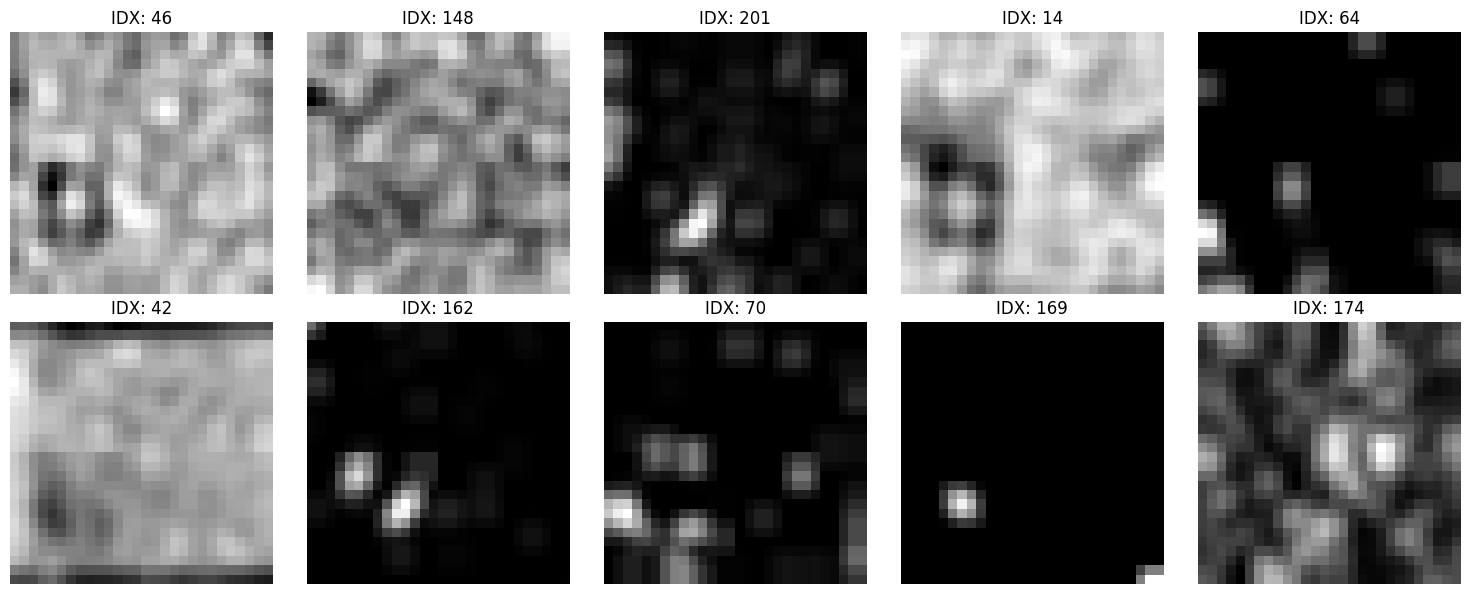

In [65]:
indices = torch.randperm(len(train_dataset))[:10]

fig , axes = plt.subplots(2,5, figsize=(15,6))
for i , idx in enumerate(indices):
    row = i // 5
    col = i % 5
    axes[row,col].imshow(features[0,idx].detach().cpu(),cmap='gray')
    axes[row,col].set_title(f"IDX: {idx}")
    axes[row,col].axis('off')
    
plt.tight_layout()
plt.show()

In [66]:
import torch.nn as nn

class FeatCAE(nn.Module):
    """Autoencoder."""

    def __init__(self, in_channels=1000, latent_dim=50, is_bn=True):
        super(FeatCAE, self).__init__()

        layers = []
        layers += [nn.Conv2d(in_channels, (in_channels + 2 * latent_dim) // 2, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            layers += [nn.BatchNorm2d(num_features=(in_channels + 2 * latent_dim) // 2)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d((in_channels + 2 * latent_dim) // 2, 2 * latent_dim, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            layers += [nn.BatchNorm2d(num_features=2 * latent_dim)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d(2 * latent_dim, latent_dim, kernel_size=1, stride=1, padding=0)]

        self.encoder = nn.Sequential(*layers)

        layers = []
        layers += [nn.Conv2d(latent_dim, 2 * latent_dim, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            layers += [nn.BatchNorm2d(num_features=2 * latent_dim)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d(2 * latent_dim, (in_channels + 2 * latent_dim) // 2, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            layers += [nn.BatchNorm2d(num_features=(in_channels + 2 * latent_dim) // 2)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d((in_channels + 2 * latent_dim) // 2, in_channels, kernel_size=1, stride=1, padding=0)]

        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [67]:
import torch.optim as optim

In [68]:
model = FeatCAE(in_channels=1536, latent_dim=100)
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train this model 



  2%|▏         | 1/50 [09:55<8:06:41, 595.95s/it]

Epoch [1/50], Loss: 0.0910, Validation Loss: 0.2725


 12%|█▏        | 6/50 [39:38<3:21:17, 274.48s/it] 

Epoch [6/50], Loss: 0.0235, Validation Loss: 0.0240


 22%|██▏       | 11/50 [53:03<1:55:43, 178.04s/it]

Epoch [11/50], Loss: 0.0191, Validation Loss: 0.0200


 32%|███▏      | 16/50 [1:06:35<1:33:10, 164.44s/it]

Epoch [16/50], Loss: 0.0165, Validation Loss: 0.0169


 42%|████▏     | 21/50 [1:55:47<6:29:56, 806.78s/it]

Epoch [21/50], Loss: 0.0139, Validation Loss: 0.0148


 52%|█████▏    | 26/50 [2:15:19<2:33:03, 382.63s/it]

Epoch [26/50], Loss: 0.0127, Validation Loss: 0.0135


 62%|██████▏   | 31/50 [2:29:16<1:04:45, 204.51s/it]

Epoch [31/50], Loss: 0.0120, Validation Loss: 0.0123


 72%|███████▏  | 36/50 [2:44:40<43:50, 187.87s/it]  

Epoch [36/50], Loss: 0.0112, Validation Loss: 0.0114


 82%|████████▏ | 41/50 [3:02:42<31:47, 211.99s/it]

Epoch [41/50], Loss: 0.0108, Validation Loss: 0.0107


 92%|█████████▏| 46/50 [3:19:39<13:40, 205.12s/it]

Epoch [46/50], Loss: 0.0095, Validation Loss: 0.0101


100%|██████████| 50/50 [3:34:29<00:00, 257.39s/it]


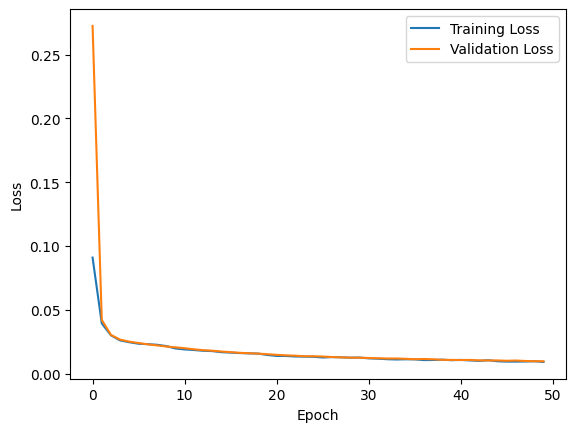

In [70]:
# Define a list to store training loss and validation loss
Loss = []
Validation_Loss = []


num_epochs = 50
for epoch in tqdm(range(num_epochs)):
    model.train()
    for data,_ in train_loader:
        with torch.no_grad():
            features = backbone(data)
        # Forward pass
        output = model(features)
        # Compute the loss
        loss = criterion(output, features)
        # Backpropagation and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    Loss.append(loss.item())

    # Calculate validation loss
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        val_loss_sum = 0.0
        num_batches = 0
        for data, _ in test_loader:
            features = backbone(data)
            output = model(features)
            val_loss = criterion(output, features)
            val_loss_sum += val_loss.item()
            num_batches += 1
        val_loss_avg = val_loss_sum / num_batches
        Validation_Loss.append(val_loss_avg)
    
    if epoch % 5 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item(), val_loss_avg))

plt.plot(Loss, label='Training Loss')
plt.plot(Validation_Loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.show()

In [73]:
torch.save(model.state_dict(), 'autoencoder_with_resnet_deep_features.pth')

In [74]:
ckpoints = torch.load('autoencoder_with_resnet_deep_features.pth')
model.load_state_dict(ckpoints)

model.eval()

/var/folders/3k/k2nhwjl51b1gvnrx1cdyrcfh0000gn/T/ipykernel_71102/2552518242.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpoints = torch.load('autoencoder_with_resne

FeatCAE(
  (encoder): Sequential(
    (0): Conv2d(1536, 868, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(868, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(868, 200, kernel_size=(1, 1), stride=(1, 1))
    (4): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(200, 100, kernel_size=(1, 1), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): Conv2d(100, 200, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(200, 868, kernel_size=(1, 1), stride=(1, 1))
    (4): BatchNorm2d(868, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(868, 1536, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [ ]:
https://github.com/mohan696matlab/mvtec_anomalydetection/blob/main/AD_3_using_resnet_backbone_multilevel.ipynb

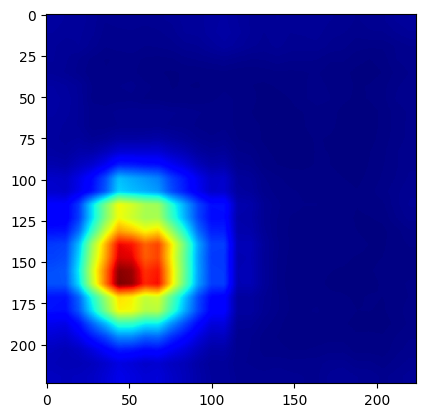

In [76]:
image = Image.open("carpet/test/color/000.png")
image = transform(image).unsqueeze(0)

with torch.no_grad():
    features = backbone(image)
    recon = model(features)

recon_error =  ((features-recon)**2).mean(axis=(1)).unsqueeze(0)

segm_map = torch.nn.functional.interpolate(     # Upscale by bi-linaer interpolation to match the original input resolution
                recon_error,
                size=(224, 224),
                mode='bilinear'
            )

plt.imshow(segm_map.squeeze().cpu().numpy(), cmap='jet')
plt.show()

In [77]:
def decision_function(segm_map):  

    mean_top_10_values = []

    for map in segm_map:
        # Flatten the tensor
        flattened_tensor = map.reshape(-1)

        # Sort the flattened tensor along the feature dimension (descending order)
        sorted_tensor, _ = torch.sort(flattened_tensor,descending=True)

        # Take the top 10 values along the feature dimension
        mean_top_10_value = sorted_tensor[:10].mean()

        mean_top_10_values.append(mean_top_10_value)

    return torch.stack(mean_top_10_values)

In [78]:
model.eval()

RECON_ERROR=[]
for data,_ in train_loader:
    
    with torch.no_grad():
        features = backbone(data).squeeze()
        # Forward pass
        recon = model(features)
    # Compute the loss
    segm_map =  ((features-recon)**2).mean(axis=(1))[:,3:-3,3:-3]
    anomaly_score = decision_function(segm_map)
    # anomaly_score = segm_map.mean(axis=(1,2))
    
    RECON_ERROR.append(anomaly_score)
    
RECON_ERROR = torch.cat(RECON_ERROR).cpu().numpy()

AttributeError: module 'numpy' has no attribute 'matrix'

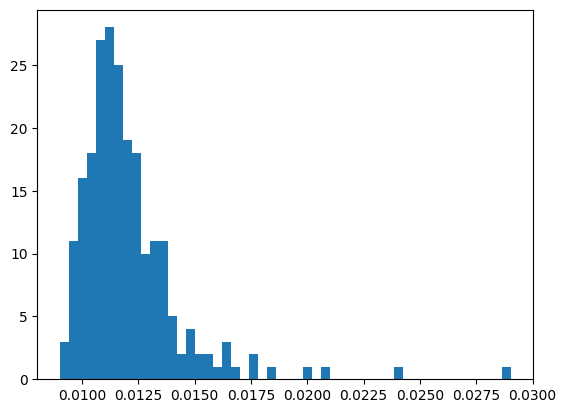

In [80]:
best_threshold = np.mean(RECON_ERROR) + 3 * np.std(RECON_ERROR)

heat_map_max, heat_map_min = np.max(RECON_ERROR), np.min(RECON_ERROR)

plt.hist(RECON_ERROR,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

In [81]:
y_true=[]
y_pred=[]
y_score=[]

model.eval()
backbone.eval()

test_path = Path('carpet/test')

for path in test_path.glob('*/*.png'):
    fault_type = path.parts[-2]
    test_image = transform(Image.open(path)).unsqueeze(0)
    
    with torch.no_grad():
        features = backbone(test_image)
        # Forward pass
        recon = model(features)
    
    segm_map = ((features - recon)**2).mean(axis=(1))[:,3:-3,3:-3]
    y_score_image = decision_function(segm_map=segm_map)
    # y_score_image = segm_map.mean(axis=(1,2))
    
    y_pred_image = 1*(y_score_image >= best_threshold)
    
    y_true_image = 0 if fault_type == 'good' else 1
    
    y_true.append(y_true_image)
    y_pred.append(y_pred_image.cpu().numpy())
    y_score.append(y_score_image.cpu().numpy())
    
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

AttributeError: module 'numpy' has no attribute 'matrix'

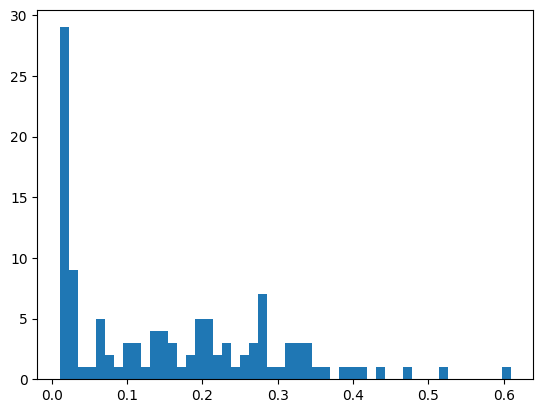

In [82]:
plt.hist(y_score,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score
import seaborn as sns



# Calculate AUC-ROC score
auc_roc_score = roc_auc_score(y_true, y_score)
print("AUC-ROC Score:", auc_roc_score)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



f1_scores = [f1_score(y_true, y_score >= threshold) for threshold in thresholds]

# Select the best threshold based on F1 score
best_threshold = thresholds[np.argmax(f1_scores)]

print(f'best_threshold = {best_threshold}')

# Generate confusion matrix
cm = confusion_matrix(y_true, (y_score >= best_threshold).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['OK','NOK'])
disp.plot()
plt.show()

In [ ]:
import cv2, time
from IPython.display import clear_output

model.eval()
backbone.eval()

test_path = Path('carpet/test')

for path in test_path.glob('*/*.png'):
    fault_type = path.parts[-2]
    test_image = transform(Image.open(path)).unsqueeze(0)
    
    with torch.no_grad():
        features = backbone(test_image)
        # Forward pass
        recon = model(features)
    
    segm_map = ((features - recon)**2).mean(axis=(1))
    y_score_image = decision_function(segm_map=segm_map)
    # y_score_image = segm_map.mean(axis=(1,2))
    
    y_pred_image = 1*(y_score_image >= best_threshold)
    class_label = ['OK','NOK']

    if fault_type in ['thread']:

        plt.figure(figsize=(15,5))

        plt.subplot(1,3,1)
        plt.imshow(test_image.squeeze().permute(1,2,0).cpu().numpy())
        plt.title(f'fault type: {fault_type}')

        plt.subplot(1,3,2)
        heat_map = segm_map.squeeze().cpu().numpy()
        heat_map = heat_map
        heat_map = cv2.resize(heat_map, (128,128))
        plt.imshow(heat_map, cmap='jet', vmin=heat_map_min, vmax=heat_map_max*10) # Here I am cheating by multiplying by 10 (obtained using trail error)
        plt.title(f'Anomaly score: {y_score_image[0].cpu().numpy() / best_threshold:0.4f} || {class_label[y_pred_image]}')

        plt.subplot(1,3,3)
        plt.imshow((heat_map > best_threshold * 10), cmap='gray')
        plt.title(f'segmentation map')
        
        plt.show()

        # time.sleep(0.05)
        # clear_output(wait=True)

        # break


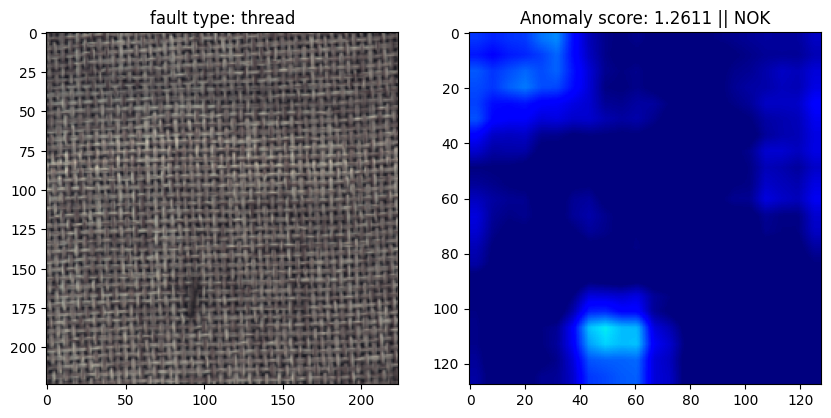

In [83]:
import cv2, time
from IPython.display import clear_output

model.eval()
backbone.eval()

test_path = Path('carpet/test')

for path in test_path.glob('*/*.png'):
    fault_type = path.parts[-2]
    test_image = transform(Image.open(path)).unsqueeze(0)
    
    with torch.no_grad():
        features = backbone(test_image)
        # Forward pass
        recon = model(features)
    
    segm_map = ((features - recon)**2).mean(axis=(1))[:,3:-3,3:-3]
    y_score_image = decision_function(segm_map=segm_map)
    # y_score_image = segm_map.mean(axis=(1,2))
    
    y_pred_image = 1*(y_score_image >= best_threshold)
    class_label = ['OK','NOK']

    if fault_type in ['color','thread']:

        plt.figure(figsize=(10,5))

        plt.subplot(1,2,1)
        plt.imshow(test_image.squeeze().permute(1,2,0).cpu().numpy())
        plt.title(f'fault type: {fault_type}')

        plt.subplot(1,2,2)
        heat_map = segm_map.squeeze().cpu().numpy()
        heat_map = heat_map
        heat_map = cv2.resize(heat_map, (128,128))
        plt.imshow(heat_map, cmap='jet', vmin=heat_map_min, vmax=heat_map_max*2)
        plt.title(f'Anomaly score: {y_score_image[0].cpu().numpy() / best_threshold:0.4f} || {class_label[y_pred_image]}')
        
        plt.show()

        time.sleep(0.05)
        clear_output(wait=True)
